# POLLUTION DATA ANALYSIS AND PREDICTION

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [6]:
weather = pd.read_csv("https://gitlab.com/pawelmroz/tabu-search/raw/master/pollution/weather_wind.csv", header=0, sep=";")

In [7]:
print(weather.head(5))

         DATE  PM10  PM25  TEMPERATURE  PRESSURE  HUMIDITY  WIND_DIRECTION  \
0  01.10.2012   121    82        13.36    992.54     71.78           261.0   
1  02.10.2012   158   136        14.20    990.88     82.17           265.0   
2  03.10.2012   115    99        13.25    989.61     84.77           247.0   
3  04.10.2012    95    60        14.64    987.41     64.57           261.0   
4  05.10.2012    42    26        12.61    989.87     60.72           261.0   

   WIND_SPEED  
0    0.764375  
1    1.159236  
2    1.586667  
3    2.334931  
4    2.827778  


## Outliers analysis

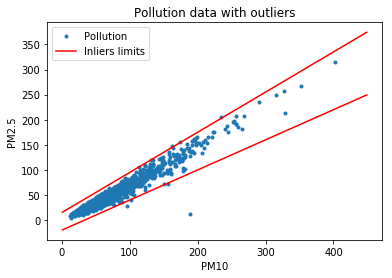

In [8]:
plt.plot(weather['PM10'], weather['PM25'], '.', label='Pollution')
x = np.arange(1, 450)
y = 0.6*x - 20
z = 0.8*x + 15
plt.plot(x, y, 'r', label='Inliers limits')
plt.plot(x, z, 'r')
plt.xlabel("PM10")
plt.ylabel("PM2.5")
plt.title('Pollution data with outliers')
plt.legend()
plt.show()

In [9]:
outliers = []
for i in range(len(weather)):
    try:
        if int(weather['PM25'][i]) < (0.6 * int(weather['PM10'][i]) - 20) or int(weather['PM25'][i]) > (0.8 * int(weather['PM10'][i]) + 15):
            outliers.append(i)
    except KeyError:
        continue

weather = weather.drop(weather.index[outliers])

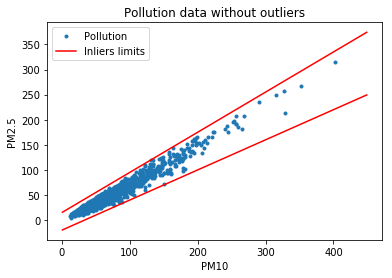

In [10]:
plt.plot(weather['PM10'], weather['PM25'], '.', label='Pollution')
x = np.arange(1, 450)
y = 0.6*x - 20
z = 0.8*x + 15
plt.plot(x, y, 'r', label='Inliers limits')
plt.plot(x, z, 'r')
plt.xlabel("PM10")
plt.ylabel("PM2.5")
plt.title('Pollution data without outliers')
plt.legend()
plt.show()

## Data correlation analysis

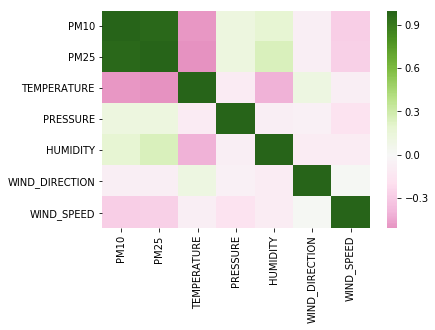

In [11]:
w = weather.iloc[:,1:8]
corr = w.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, center=0, cmap="PiYG")

In [12]:
weather = weather[weather["TEMPERATURE"].notnull()]
weather = weather[weather["PRESSURE"].notnull()]
weather = weather[weather["HUMIDITY"].notnull()]
weather = weather[weather["WIND_DIRECTION"].notnull()]
weather = weather[weather["WIND_SPEED"].notnull()]

## Clustering

In [13]:
def cluster(data, n, init):
    cmap = {0: 'g', 1: 'y', 2: 'r', 3: 'b', 4: 'k'}
    km = KMeans(n, init=init)
    clst = km.fit_predict(data)
    plt.scatter(data["PM10"], data["PM25"], c=[cmap[l] for l in clst])
    plt.xlabel('PM10')
    plt.ylabel('PM2.5')
    plt.title('Clusters for pollution data')
    plt.show()
    return clst

c:\python36\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


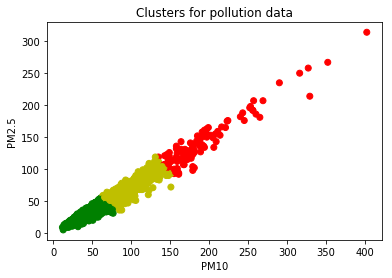

In [14]:
init3 = np.array([[0, 0], [100, 100], [200, 200]])
weather["message"] = cluster(weather[["PM10", "PM25"]], 3, init3)
weather = weather.drop(["PM10", "PM25"], axis=1)

## Training a model

In [15]:
train, test = train_test_split(weather, test_size=0.2)
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(train.iloc[:, 1:6],train.iloc[:, 6])
pred = clf.predict(test.iloc[:, 1:6])

In [16]:
cnt = 0
for a, b in zip(pred,test.iloc[:, 6]):
    # print("pred: ", a," - real: ", b)
    if a == b:
        cnt += 1
print("acc: ", cnt/len(pred))

acc:  0.7810650887573964


## Visualisation

In [17]:
from pixiedust.display.app import *
from IPython.display import display as disp
from urllib.request import urlopen
import folium

@PixieApp
class PollutionForecast:
    @route()
    def main(self):
        config = open('js.txt', 'r')
        config = config.read()
        #config = urlopen('https://gitlab.com/pawelmroz/tabu-search/raw/master/pollution/js.txt').read()
        return config
        
    def get_data(self, location):
        apikey = 'f5c41c88f7c9c02fcd1ab064d1274920'
        if location == 1: #Mydlniki
            url = 'http://api.openweathermap.org/data/2.5/forecast?q=Mydlniki,PL&APPID={}'.format(apikey)
        if location == 2: #Srodmiescie
            url = 'http://api.openweathermap.org/data/2.5/forecast?lat=50.07&lon=19.94&APPID={}'.format(apikey)
        if location == 3: #Podgorze
            url = 'http://api.openweathermap.org/data/2.5/forecast?lat=50.01&lon=19.96&APPID={}'.format(apikey)
        if location == 4: #Debniki
            url = 'http://api.openweathermap.org/data/2.5/forecast?lat=50.02&lon=19.87&APPID={}'.format(apikey)
        if location == 5: #Nowa Huta
            url = 'http://api.openweathermap.org/data/2.5/forecast?lat=50.07&lon=20.03&APPID={}'.format(apikey)
        response = requests.get(url, stream=True).json()
        return response

    def response_to_dataframe(self, response):
        list_of_days = [7, 15, 23, 31, 39]
        list = []
        for el in list_of_days:
            temp = round(response['list'][el]['main']['temp'] - 273, 2)
            pressure = response['list'][el]['main']['pressure']
            humidity = response['list'][el]['main']['humidity']
            wind_dir = response['list'][el]['wind']['deg']
            wind_speed = response['list'][el]['wind']['speed']
            sub_list = [temp, pressure, humidity, wind_dir, wind_speed]
            list.append(sub_list)
        columns = ['TEMPERATURE', 'PRESSURE', 'HUMIDITY', 'WIND_DIRECTION', 'WIND_SPEED']
        data = pd.DataFrame(list, columns=columns)
        return data
    
    def show_poll(self, ind):
        global clf
        if ind == 1:
            mydlniki = self.response_to_dataframe(self.get_data(1))
            mydlniki['PREDICTION'] = clf.predict(mydlniki)
            return mydlniki
        elif ind == 2:
            centrum = self.response_to_dataframe(self.get_data(2))
            centrum['PREDICTION'] = clf.predict(centrum)
            return centrum
        elif ind == 3:
            podgorze = self.response_to_dataframe(self.get_data(3))
            podgorze['PREDICTION'] = clf.predict(podgorze)
            return podgorze
        elif ind == 4:
            debniki = self.response_to_dataframe(self.get_data(4))
            debniki['PREDICTION'] = clf.predict(debniki)
            return debniki
        else:
            huta = self.response_to_dataframe(self.get_data(5))
            huta['PREDICTION'] = clf.predict(huta)
            return huta
    
    def pollution_map(self, day):
        print("Map is loading... \n")
        names = {0: 'Clear',1:'Warning',2:'Alarm'}
        col = {0: 'green',1:'orange',2:'red'}
        map_osm = folium.Map(location=[50.0614, 19.9365], zoom_start=12)
        mydlniki = self.show_poll(1)
        centrum = self.show_poll(2)
        podgorze = self.show_poll(3)
        debniki = self.show_poll(4)
        huta = self.show_poll(5)
        try:
            poll_level = mydlniki['PREDICTION']
            poll_level2 = centrum['PREDICTION']
            poll_level3 = podgorze['PREDICTION']
            poll_level4 = debniki['PREDICTION']
            poll_level5 = huta['PREDICTION']
            
            my_val = day
            
            folium.Circle([50.08, 19.85],radius=2500,popup=names[poll_level[my_val]],
                        color=col[poll_level[my_val]],fill=True).add_to(map_osm)
            folium.Circle([50.07, 19.94],radius=2500,popup=names[poll_level2[my_val]],
                        color=col[poll_level2[my_val]],fill=True).add_to(map_osm)
            folium.Circle([50.01, 19.96],radius=2500,popup=names[poll_level3[my_val]],
                        color=col[poll_level3[my_val]],fill=True).add_to(map_osm)
            folium.Circle([50.02, 19.87],radius=2500,popup=names[poll_level4[my_val]],
                        color=col[poll_level4[my_val]],fill=True).add_to(map_osm)
            
            folium.Circle([50.07, 20.03],radius=2500,popup=names[poll_level5[my_val]],
                        color=col[poll_level5[my_val]],fill=True).add_to(map_osm)
            print(poll_level[my_val])
            folium.Marker([50.08, 19.85], icon=folium.Icon(color=col[poll_level[my_val]]), popup='Mydlniki').add_to(map_osm)
            folium.Marker([50.07, 19.94], icon=folium.Icon(color=col[poll_level2[my_val]]), popup='Cracow city center').add_to(map_osm)
            folium.Marker([50.01, 19.96], icon=folium.Icon(color=col[poll_level3[my_val]]), popup='Podgórze').add_to(map_osm)
            folium.Marker([50.02, 19.87], icon=folium.Icon(color=col[poll_level4[my_val]]), popup='Dębniki').add_to(map_osm)
            folium.Marker([50.07, 20.03], icon=folium.Icon(color=col[poll_level5[my_val]]), popup='Nowa Huta').add_to(map_osm)
            
            disp(map_osm)
        except:
            print(sys.exc_info())
               

#run the app
PollutionForecast().run(runInDialog='false')